Covariant shift detection for tabular data 

This example of feature drift detection for tabular data is inspired by
https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_online_wine.html


In [1]:
import sys 
sys.path.append("../../") # Adding path to project root for this specific notebook

In [2]:
import pandas as pd
import numpy as np

red = pd.read_csv(
    "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-red.csv", sep=';'
)
white = pd.read_csv(
    "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-white.csv", sep=';'
)
white = white.drop(["quality"], axis=1)
red = red.drop(["quality"], axis=1)
white_test = white[400:800].astype(np.float64)
white = white[:400].astype(np.float64)
red = red[:400].astype(np.float64)


In [3]:
from drifting import DriftingClient, DriftType

client = DriftingClient()
detector_name = "WineDriftDetector"


In [4]:
client.fit(white, drift_type=DriftType.TABULAR, detector_name=detector_name, ert=400, window_size=40, n_bootstraps=7000)

<Response [200]>

In [5]:
client.load(detector_name=detector_name)

<Response [200]>

In [6]:
# Use white test to check if the detector didn't overfit
red_white_red = pd.concat([red, white_test, red], axis=0)
drifts, test_stats = [], []
for i in range(len(red_white_red)):
    is_drift, test_stat = client.predict(red_white_red.iloc[[i], :], drift_type=DriftType.TABULAR, detector_name=detector_name)
    # print(response)
    test_stats.append(test_stat)
    if is_drift:
        # The drift detector indicates after each sample if there is a drift in the data
        drifts.append(i)


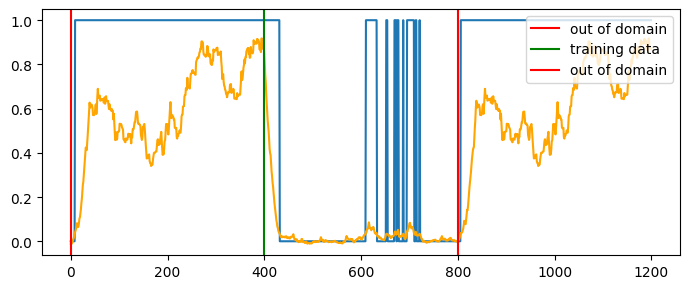

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,3), tight_layout=True)

detections = np.zeros((len(red_white_red, )))
detections[drifts] = 1
plt.plot(detections)
plt.plot(test_stats, 'orange')
plt.axvline(0, color='red', label="out of domain")
plt.axvline(400, color='green', label="training data")
plt.axvline(800, color='red', label="out of domain")
plt.legend(loc='upper right')


We can see that the red wine rows where detected as drifted, and most of the
white wines are correctly detected as not drifted.